In [1]:
# Import necessary modules
import numpy as np
import pandas as pd 
from matplotlib import pyplot
import matplotlib.pyplot as plt  # For plotting graphs 
%matplotlib inline

import cufflinks as cf 
from IPython.display import display, HTML, Image
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go

# standardizes the size of all plots, rather than typing plot(figsize = (12,6)) everytime
from pylab import rcParams
rcParams['figure.figsize'] = 12,6 

from scipy import stats
from datetime import datetime
from functools import reduce
import datetime

from fredapi import Fred
import quandl

import scipy as sp
from statsmodels.tsa.stattools import coint # perform Johansen cointegration test
import statsmodels.stats.api as sms
import statsmodels.api as sm # to make regressions 
from statsmodels.stats.diagnostic import het_white # test for heteroskedasticity


from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.tsa.stattools import ccovf,ccf,periodogram
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import scipy.stats as sp # SciPy for linear regression.

quandl.ApiConfig.api_key = '-kesKc4A8jkkBwyX3rSX'
fred = Fred(api_key='7e70df3f020852ea824275ce0fea70a0')

In [99]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# imported the relavant macroecon variables
laborl = ["FRED/LNS12300060", # Employment to population ratio: 25-54 Yrs
         "FRED/UNRATE",    # U3 Unemployment rate
         "FRED/CIVPART"] # Labor Force Participation Rate

                  

labor = quandl.get(laborl, start_date="1990-01-01", end_date="2012-06-01",collapse = 'monthly',date_parser=parser)
labor.columns = ['epop', 'unrate', 'lfpr']
labor.head()

epop  unrate  lfpr
Date                          
1990-01-31  80.2     5.4  66.8
1990-02-28  80.2     5.3  66.7
1990-03-31  80.1     5.2  66.7
1990-04-30  79.9     5.4  66.6
1990-05-31  79.9     5.4  66.6

In [3]:
price0 = quandl.get("FRED/PCEPI", start_date="1982-01-01", end_date="2012-06-01",collapse = 'quarterly',
                   date_parser=parser)
price0.columns = ['pceindex']
price0.head()

pceindex
Date                
1982-03-31    46.742
1982-06-30    47.384
1982-09-30    47.946
1982-12-31    48.432
1983-03-31    48.804

In [4]:
eciwag = pd.read_excel(r'eciwag.xlsx')
eciwag.head()

eciwag
0    39.8
1    40.4
2    41.2
3    41.8
4    42.3

In [5]:
price = price0.merge(eciwag, left_on=eciwag.index, right_index=True).drop('key_0', 1)
price.head()

pceindex  eciwag
Date                        
1982-03-31    46.742    39.8
1982-06-30    47.384    40.4
1982-09-30    47.946    41.2
1982-12-31    48.432    41.8
1983-03-31    48.804    42.3

In [6]:
# calculate the percent change from 1 year (or 12 months ago) ago
price1 = pd.concat([price, price[['eciwag', 'pceindex']].pct_change(4).add_suffix("_ch")], axis=1).dropna()
price1.head()

pceindex  eciwag  eciwag_ch  pceindex_ch
Date                                                
1983-03-31    48.804    42.3   0.062814     0.044115
1983-06-30    49.349    43.0   0.064356     0.041470
1983-09-30    50.014    43.5   0.055825     0.043132
1983-12-31    50.198    44.1   0.055024     0.036463
1984-03-31    50.922    44.8   0.059102     0.043398

In [7]:
price_list = price1[['pceindex_ch','eciwag_ch']]

for variable in price_list:
    price1[variable] = price1[variable]*100

price1.tail()    

pceindex  eciwag  eciwag_ch  pceindex_ch
Date                                                
2011-06-30    98.136   114.7   2.137133     2.788194
2011-09-30    98.699   115.1   2.039007     3.055141
2011-12-31    98.965   115.6   2.030009     2.601186
2012-03-31    99.737   116.3   2.017544     2.351046
2012-06-30    99.701   116.8   1.830863     1.594726

In [8]:
# 4 quarter (or 12 months) moving average of PCE Price Index
price1['pceindex_ch_ma12'] = price1.iloc[:,3].rolling(window=4).mean() 
price1.drop(price1.head(12).index,inplace= True)# drop the first row with missing values as it contains NaN
price1.head()

pceindex  eciwag  eciwag_ch  pceindex_ch  pceindex_ch_ma12
Date                                                                  
1986-03-31    54.029    48.8   4.051173     2.459607          3.264348
1986-06-30    54.218    49.1   3.586498     2.147783          2.920191
1986-09-30    54.477    49.4   3.131524     1.875678          2.522772
1986-12-31    54.746    49.9   3.312629     1.569573          2.013160
1987-03-31    55.341    50.3   3.073770     2.428326          2.005340

In [81]:
labor.loc['1986-03-31':,'output_gap']

Date
1990-01-31    -5.804616
1990-02-28          NaN
1990-03-31          NaN
1990-04-30    -5.482548
1990-05-31          NaN
                ...    
2012-02-29          NaN
2012-03-31          NaN
2012-04-30    43.112374
2012-05-31          NaN
2012-06-30          NaN
Name: output_gap, Length: 270, dtype: float64

In [96]:
# imported the relavant macroecon variables
labor_gap = [ "FRED/UNRATE", 
             "FRED/NROUST"] # Short term NAIRU (natural rate of unemployment or 
                                    # non-accelerating inflation adjusted unrate)
                  

labor2 = quandl.get(labor_gap, start_date="1986-01-01", end_date="2012-06-01",collapse = 'quarterly',date_parser=parser)
labor2.columns = ['unrate', 'nairu']
labor2['unrate_gap'] = ((labor2['unrate'] - labor2['nairu'])/labor2['nairu'])*100
labor2.head()

unrate     nairu  unrate_gap
Date                                    
1986-03-31     7.2  5.997622   20.047579
1986-06-30     7.2  5.986110   20.278445
1986-09-30     7.0  5.973968   17.175059
1986-12-31     6.6  5.961125   10.717349
1987-03-31     6.6  5.947526   10.970520

In [98]:
unrategap = pd.merge(price1, labor2, on = 'Date')
unrategap.head()

pceindex  eciwag  eciwag_ch  pceindex_ch  pceindex_ch_ma12  \
Date                                                                     
1986-03-31    54.029    48.8   4.051173     2.459607          3.264348   
1986-06-30    54.218    49.1   3.586498     2.147783          2.920191   
1986-09-30    54.477    49.4   3.131524     1.875678          2.522772   
1986-12-31    54.746    49.9   3.312629     1.569573          2.013160   
1987-03-31    55.341    50.3   3.073770     2.428326          2.005340   

            unrate     nairu  unrate_gap  
Date                                      
1986-03-31     7.2  5.997622   20.047579  
1986-06-30     7.2  5.986110   20.278445  
1986-09-30     7.0  5.973968   17.175059  
1986-12-31     6.6  5.961125   10.717349  
1987-03-31     6.6  5.947526   10.970520

In [9]:
fig_price = price1[['eciwag_ch', 'pceindex_ch', 'pceindex_ch_ma12']].iplot(asFigure=True, kind='scatter', 
                                            xTitle='Date', yTitle='% Change in Prices')
fig_price.update_layout(
    title={
        'text': 'Year-over-Year % Change in Measures of Inflation: ECI Wage Growth and PCE Inflation Rate',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig_price.show()

In [10]:
fig_price.write_html("fig_price.html")

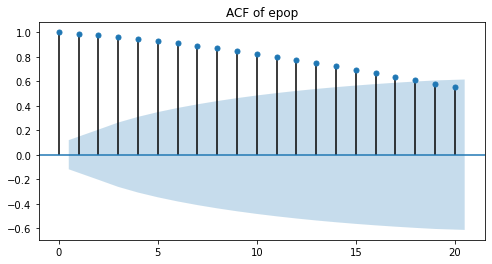

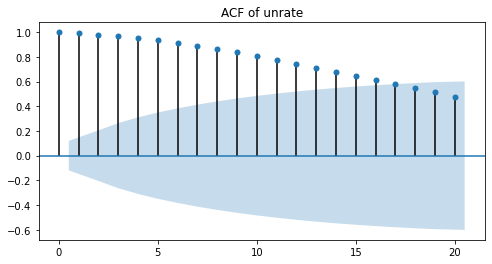

In [11]:
# ACF of labor utilization variables
rcParams['figure.figsize'] = 8,4

for variable in labor.columns:
    plot_acf(labor[variable], lags = 20, title = 'ACF of ' + variable)


In [12]:
def adfuller_test(series, signif = 0.05, name = '', verbose = False):
    """Perform ADFuller to test for stationarity of a given series and print report"""
    
    r = adfuller(series, autolag = 'AIC')
    output = {'test_statistic': round(r[0], 4), 'pvalue': round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length = 6): return str(val).ljust(length)
    
    # print sumamry
    print(f'     Augmented Dickey-Fuller Test on "{name}"', "\n    ", '-'*47)
    print(f'  Null Hypothesis: Data has unit too. Non-Stationary.')
    print(f'  Significance Level    = {signif}')
    print(f'  Test Statistic        = {output["test_statistic"]}')
    print(f'  No. of Lags Chosen    = {output["n_lags"]}')
          
    for key, val in r[4].items():
          print(f'  Critical Value {adjust(key)} = {round(val, 3)}')
          
    if p_value <= signif:
          print(f" => P-Value = {p_value}. Rejecting null hypothesis.")
          print(f" => Series is stationary.")
    else:
          print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
          print(f" => Series is non-stationary.")

In [13]:
# ADF Test on each column in labor
for name, column in labor.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

     Augmented Dickey-Fuller Test on "epop" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -0.8951
  No. of Lags Chosen    = 5
  Critical Value 1%     = -3.455
  Critical Value 5%     = -2.873
  Critical Value 10%    = -2.573
 => P-Value = 0.7896. Weak evidence to reject the Null Hypothesis.
 => Series is non-stationary.


     Augmented Dickey-Fuller Test on "unrate" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -2.3495
  No. of Lags Chosen    = 7
  Critical Value 1%     = -3.456
  Critical Value 5%     = -2.873
  Critical Value 10%    = -2.573
 => P-Value = 0.1565. Weak evidence to reject the Null Hypothesis.
 => Series is non-stationary.




In [14]:
# stationarizes the labor variables by differencing, and concats them with the dataset
labor1 = pd.concat([labor[['epop', 'unrate']].diff().add_suffix("_diff"), labor], axis = 1)
#stat = pd.concat([short, short1], axis=1)

# drops rows with NaN values, and replaces inf values with 0
stat = labor1.dropna(inplace = False).replace([np.inf, -np.inf], 0).dropna(axis=1)
stat.tail()

epop_diff  unrate_diff  epop  unrate
Date                                            
2012-02-29        0.0          0.0  75.5     8.3
2012-03-31        0.2         -0.1  75.7     8.2
2012-04-30        0.0          0.0  75.7     8.2
2012-05-31        0.0          0.0  75.7     8.2
2012-06-30       -0.1          0.0  75.6     8.2

In [15]:
fig_labor = labor1[['unrate_diff', 'epop_diff']].iplot(asFigure=True, kind='scatter', #layout = layout,
                                            xTitle='Date', yTitle='First Differenced Values')
fig_labor.update_layout(
    title={
        'text': "First Differenced Measures of Labor Utilization: Unemployment Rate and EPOP",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig_labor.show()

In [16]:
# ADF Test on the first difference of labor variables => no unit root
for name, column in stat[['epop_diff', 'unrate_diff']].iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

     Augmented Dickey-Fuller Test on "epop_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -4.7202
  No. of Lags Chosen    = 4
  Critical Value 1%     = -3.455
  Critical Value 5%     = -2.873
  Critical Value 10%    = -2.573
 => P-Value = 0.0001. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "unrate_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -3.4919
  No. of Lags Chosen    = 5
  Critical Value 1%     = -3.455
  Critical Value 5%     = -2.873
  Critical Value 10%    = -2.573
 => P-Value = 0.0082. Rejecting null hypothesis.
 => Series is stationary.




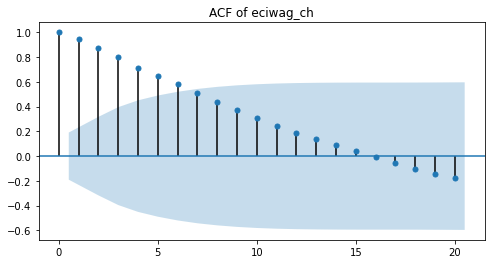

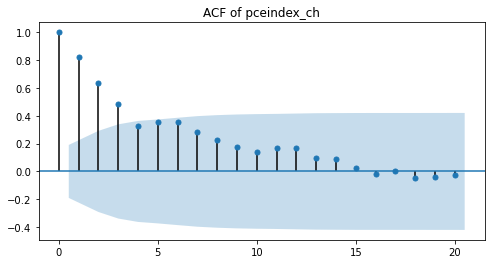

In [17]:
# ACF of labor utilization variables
rcParams['figure.figsize'] = 8,4

price_ch = price1[['eciwag_ch', 'pceindex_ch']]

for variable in price_ch.columns:
    plot_acf(price_ch[variable], lags = 20, title = 'ACF of ' + variable)

In [18]:
# ADF Test on the % change measures of inflation => still have unit root
for name, column in price1[['eciwag_ch', 'pceindex_ch']].iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

     Augmented Dickey-Fuller Test on "eciwag_ch" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -1.0578
  No. of Lags Chosen    = 8
  Critical Value 1%     = -3.5
  Critical Value 5%     = -2.892
  Critical Value 10%    = -2.583
 => P-Value = 0.7316. Weak evidence to reject the Null Hypothesis.
 => Series is non-stationary.


     Augmented Dickey-Fuller Test on "pceindex_ch" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -1.9135
  No. of Lags Chosen    = 12
  Critical Value 1%     = -3.503
  Critical Value 5%     = -2.893
  Critical Value 10%    = -2.584
 => P-Value = 0.3258. Weak evidence to reject the Null Hypothesis.
 => Series is non-stationary.




In [19]:
stat.describe() # sd of labor utillization measures

epop_diff  unrate_diff        epop      unrate
count  269.000000   269.000000  269.000000  269.000000
mean    -0.017100     0.010409   79.054647    6.033457
std      0.176209     0.156821    1.842033    1.618410
min     -0.600000    -0.500000   74.800000    3.800000
25%     -0.100000    -0.100000   78.600000    4.700000
50%      0.000000     0.000000   79.400000    5.600000
75%      0.100000     0.100000   80.100000    6.900000
max      0.500000     0.500000   81.900000   10.000000

In [20]:
price1[['pceindex_ch', 'eciwag_ch', 'pceindex_ch_ma12']].describe() #  sd of inflation measures

pceindex_ch   eciwag_ch  pceindex_ch_ma12
count   106.000000  106.000000        106.000000
mean      2.380991    3.418620          2.402669
std       1.096540    0.878081          0.971622
min      -0.817910    1.368613         -0.411196
25%       1.920190    2.972452          1.982048
50%       2.328148    3.387176          2.320869
75%       2.858287    3.878342          2.829312
max       4.985011    5.405405          4.506214

In [21]:
labor[['unrate', 'epop']].corr()

unrate      epop
unrate  1.000000 -0.956901
epop   -0.956901  1.000000

In [22]:
price1[['pceindex_ch', 'eciwag_ch', 'pceindex_ch_ma12']].corr()

pceindex_ch  eciwag_ch  pceindex_ch_ma12
pceindex_ch          1.000000   0.567925          0.828890
eciwag_ch            0.567925   1.000000          0.652714
pceindex_ch_ma12     0.828890   0.652714          1.000000

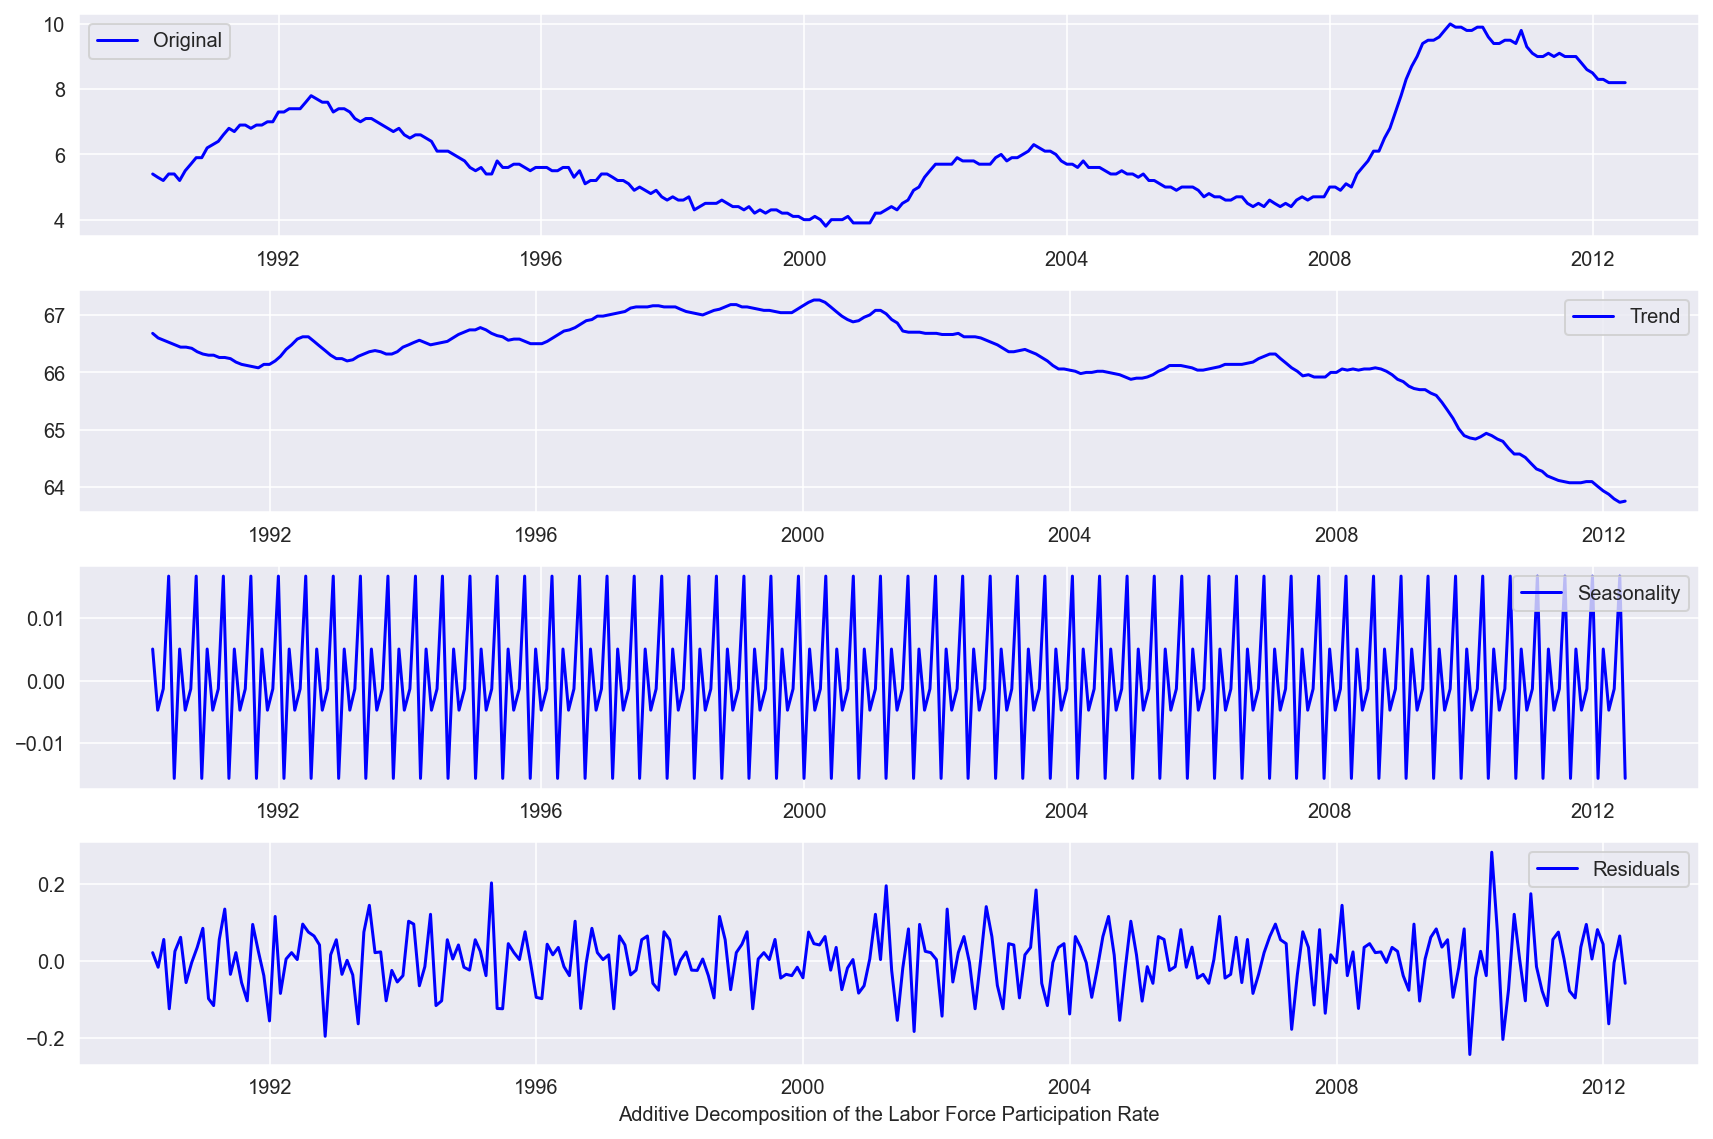

In [123]:
decomposition = seasonal_decompose(labor['lfpr'], model='additive', period = 5)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)

plt.plot(labor['unrate'], label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)

plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)

plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)

plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.xlabel('Additive Decomposition of the Labor Force Participation Rate')
plt.tight_layout()

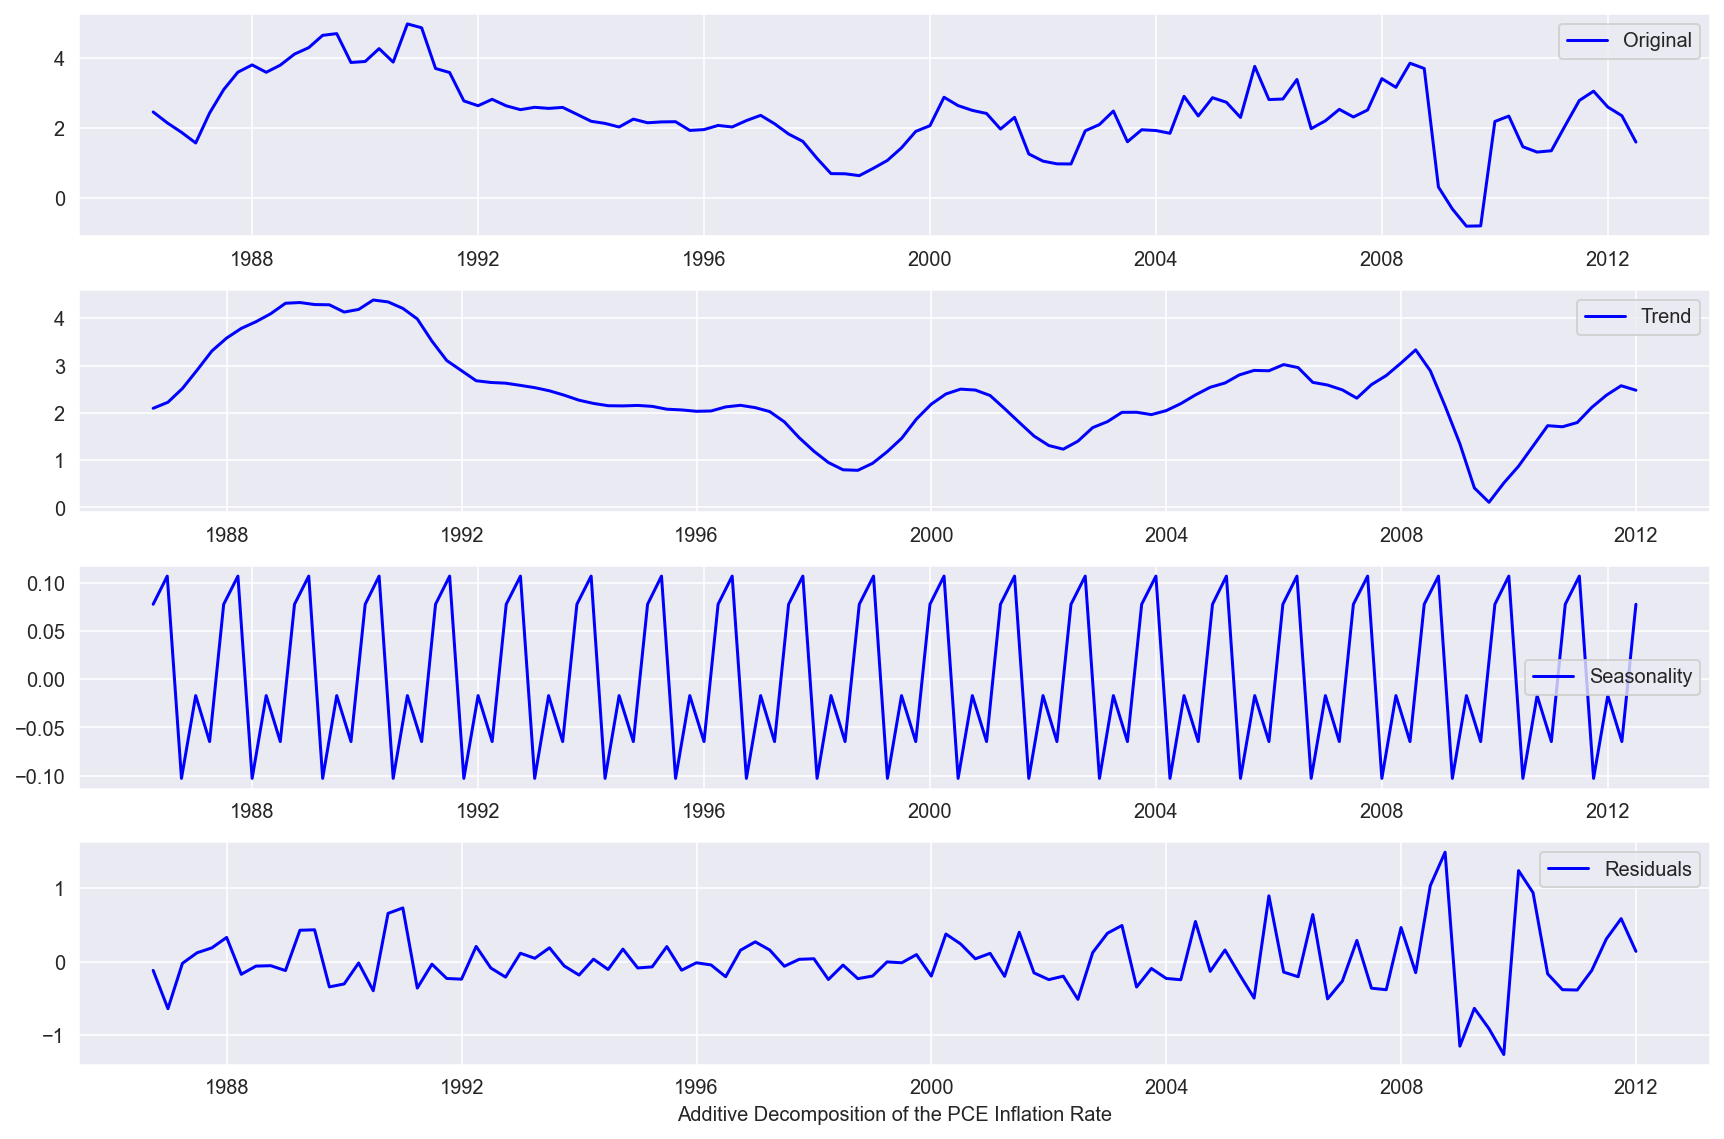

In [124]:
decomposition = seasonal_decompose(price1['pceindex_ch'], model='additive', period = 5)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)

plt.plot(price1['pceindex_ch'], label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)

plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)

plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)

plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.xlabel('Additive Decomposition of the PCE Inflation Rate')
plt.tight_layout()

In [26]:
y = stat['epop_diff']
X = stat['unrate_diff']
X = sm.add_constant(X) ## add an intercept (beta_0) to the model


mod = sm.OLS(y, X).fit() ## sm.OLS(output, input)
epop_diff_pred = mod.predict(X) 

# Print out the statistics
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              epop_diff   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     77.47
Date:                Wed, 15 Jul 2020   Prob (F-statistic):           1.72e-16
Time:                        17:00:37   Log-Likelihood:                 120.08
No. Observations:                 269   AIC:                            -236.2
Df Residuals:                     267   BIC:                            -229.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0116      0.009     -1.217      0.225      -0.030       0.007
unrate_diff    -0.5329      0.061     -8.802      0.000      -0.652      -0.414
==============================================================================
Omnibus:                        0.286   Durbin-Watson:                   2.333
Prob(Omnibus):                  0.867   Jarque-Bera (JB):                0.107
Skew:                          -0.004   Prob(JB):                        0.948
Kurtosis:                       3.097   Cond. No.                         6.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

b_1 = change in the growth of y for a unit change in growth of x.

So, the growth of epop falls by 0.5329 when the growth of unrate increases by 1 unit.

In [27]:
labor['target_epop'] = 0.0116+0.5329*(6.5 - labor['unrate']) + labor['epop']
labor['target_epop'].describe()

count    270.000000
mean      79.320360
std        2.675617
min       72.999740
25%       78.398440
50%       79.961275
75%       81.074110
max       83.350430
Name: target_epop, dtype: float64

In [28]:
pred = pd.DataFrame(epop_diff_pred, columns = ['epop_diff_pred'])
pred.head()

epop_diff_pred
Date                      
1990-02-28        0.041734
1990-03-31        0.041734
1990-04-30       -0.118129
1990-05-31       -0.011554
1990-06-30        0.095022

In [29]:
def invert_diff(history, yhat, interval=1):
    return yhat + history[-interval]

invert = invert_diff(stat['epop'], pred['epop_diff_pred'], 1).to_frame()
invert.rename(columns={'epop_diff_pred':'invert_epop_pred'}, inplace=True)
merge_invert = pd.merge(stat, invert, how='inner', left_index=True, right_index=True)
merge_invert.tail()

epop_diff  unrate_diff  epop  unrate  invert_epop_pred
Date                                                              
2012-02-29        0.0          0.0  75.5     8.3         75.588446
2012-03-31        0.2         -0.1  75.7     8.2         75.641734
2012-04-30        0.0          0.0  75.7     8.2         75.588446
2012-05-31        0.0          0.0  75.7     8.2         75.588446
2012-06-30       -0.1          0.0  75.6     8.2         75.588446

In [30]:
# calculate the percent change from 1 year (or 12 months ago) ago
labor2 = pd.concat([labor, labor[['unrate','epop']].pct_change(12).add_suffix("_ch")], axis=1)
labor2.drop(labor2.head(12).index,inplace= True)# drop the first row with missing values as it contains NaN

labor2_list = labor2[['unrate_ch','epop_ch']]

for variable in labor2_list:
    labor2[variable] = labor2[variable]*100

labor2.tail()   

epop  unrate  target_epop  unrate_ch   epop_ch
Date                                                      
2012-02-29  75.5     8.3     74.55238  -7.777778  0.532623
2012-03-31  75.7     8.2     74.80567  -8.888889  0.531208
2012-04-30  75.7     8.2     74.80567  -9.890110  0.798935
2012-05-31  75.7     8.2     74.80567  -8.888889  0.664894
2012-06-30  75.6     8.2     74.70567  -9.890110  0.800000

In [31]:
fig_price = labor2[['unrate_ch', 'epop_ch']].iplot(asFigure=True, kind='scatter', 
                                            xTitle='Date', yTitle='% Change in unrate and epop')
fig_price.update_layout(
    title={
        'text': 'Year-over-Year % Change in the Measures of Labor Utilization',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig_price.show()

In [32]:
from numpy import zeros, ones, flipud, log
from numpy.linalg import inv, eig, cholesky as chol
from statsmodels.regression.linear_model import OLS


tdiff = np.diff

class Holder(object):
    pass

def rows(x):
    return x.shape[0]

def trimr(x, front, end):
    if end > 0:
        return x[front:-end]
    else:
        return x[front:]

import statsmodels.tsa.tsatools as tsat
mlag = tsat.lagmat

def mlag_(x, maxlag):
    '''return all lags up to maxlag
    '''
    return x[:-lag]

def lag(x, lag):
    return x[:-lag]

def detrend(y, order):
    if order == -1:
        return y
    return OLS(y, np.vander(np.linspace(-1, 1, len(y)), order + 1)).fit().resid

def resid(y, x):
    r = y - np.dot(x, np.dot(np.linalg.pinv(x), y))
    return r




def coint_johansen(x, p, k, print_on_console=True):

    #    % error checking on inputs
    #    if (nargin ~= 3)
    #     error('Wrong # of inputs to johansen')
    #    end
    nobs, m = x.shape

    # why this?  f is detrend transformed series, p is detrend data
    if (p > -1):
        f = 0
    else:
        f = p

    x = detrend(x, p)
    dx = tdiff(x, 1, axis=0)
    # dx    = trimr(dx,1,0)
    z = mlag(dx, k)  # [k-1:]
#    print z.shape
    z = trimr(z, k, 0)
    z = detrend(z, f)
#    print dx.shape
    dx = trimr(dx, k, 0)

    dx = detrend(dx, f)
    # r0t   = dx - z*(z\dx)
    r0t = resid(dx, z)  # diff on lagged diffs
    # lx = trimr(lag(x,k),k,0)
    lx = lag(x, k)
    lx = trimr(lx, 1, 0)
    dx = detrend(lx, f)
#    print 'rkt', dx.shape, z.shape
    # rkt   = dx - z*(z\dx)
    rkt = resid(dx, z)  # level on lagged diffs
    skk = np.dot(rkt.T, rkt) / rows(rkt)
    sk0 = np.dot(rkt.T, r0t) / rows(rkt)
    s00 = np.dot(r0t.T, r0t) / rows(r0t)
    sig = np.dot(sk0, np.dot(inv(s00), (sk0.T)))
    tmp = inv(skk)
    # du, au = eig(np.dot(tmp, sig))
    au, du = eig(np.dot(tmp, sig))  # au is eval, du is evec
    # orig = np.dot(tmp, sig)

    # % Normalize the eigen vectors such that (du'skk*du) = I
    temp = inv(chol(np.dot(du.T, np.dot(skk, du))))
    dt = np.dot(du, temp)


    # JP: the next part can be done much  easier

    # %      NOTE: At this point, the eigenvectors are aligned by column. To
    # %            physically move the column elements using the MATLAB sort,
    # %            take the transpose to put the eigenvectors across the row

    # dt = transpose(dt)

    # % sort eigenvalues and vectors

    # au, auind = np.sort(diag(au))
    auind = np.argsort(au)
    # a = flipud(au)
    aind = flipud(auind)
    a = au[aind]
    # d = dt[aind,:]
    d = dt[:, aind]

    # %NOTE: The eigenvectors have been sorted by row based on auind and moved to array "d".
    # %      Put the eigenvectors back in column format after the sort by taking the
    # %      transpose of "d". Since the eigenvectors have been physically moved, there is
    # %      no need for aind at all. To preserve existing programming, aind is reset back to
    # %      1, 2, 3, ....

    # d  =  transpose(d)
    # test = np.dot(transpose(d), np.dot(skk, d))

    # %EXPLANATION:  The MATLAB sort function sorts from low to high. The flip realigns
    # %auind to go from the largest to the smallest eigenvalue (now aind). The original procedure
    # %physically moved the rows of dt (to d) based on the alignment in aind and then used
    # %aind as a column index to address the eigenvectors from high to low. This is a double
    # %sort. If you wanted to extract the eigenvector corresponding to the largest eigenvalue by,
    # %using aind as a reference, you would get the correct eigenvector, but with sorted
    # %coefficients and, therefore, any follow-on calculation would seem to be in error.
    # %If alternative programming methods are used to evaluate the eigenvalues, e.g. Frame method
    # %followed by a root extraction on the characteristic equation, then the roots can be
    # %quickly sorted. One by one, the corresponding eigenvectors can be generated. The resultant
    # %array can be operated on using the Cholesky transformation, which enables a unit
    # %diagonalization of skk. But nowhere along the way are the coefficients within the
    # %eigenvector array ever changed. The final value of the "beta" array using either method
    # %should be the same.


    # % Compute the trace and max eigenvalue statistics */
    lr1 = zeros(m)
    lr2 = zeros(m)
    cvm = zeros((m, 3))
    cvt = zeros((m, 3))
    iota = ones(m)
    t, junk = rkt.shape
    for i in range(0, m):
        tmp = trimr(log(iota - a), i , 0)
        lr1[i] = -t * np.sum(tmp, 0)  # columnsum ?
        # tmp = np.log(1-a)
        # lr1[i] = -t * np.sum(tmp[i:])
        lr2[i] = -t * log(1 - a[i])
        cvm[i, :] = c_sja(m - i, p)
        cvt[i, :] = c_sjt(m - i, p)
        aind[i] = i
    # end

    result = Holder()
    # % set up results structure
    # estimation results, residuals
    result.rkt = rkt
    result.r0t = r0t
    result.eig = a
    result.evec = d  # transposed compared to matlab ?
    result.lr1 = lr1
    result.lr2 = lr2
    result.cvt = cvt
    result.cvm = cvm
    result.ind = aind
    result.meth = 'johansen'

    if print_on_console == True:
        print ('--------------------------------------------------')
        print ('--> Trace Statistics')
        print ('variable statistic Crit-90% Crit-95%  Crit-99%')
        for i in range(len(result.lr1)):
            print ('r =', i, '\t', round(result.lr1[i], 4), result.cvt[i, 0], result.cvt[i, 1], result.cvt[i, 2])
        print ('--------------------------------------------------')
        print ('--> Eigen Statistics')
        print ('variable statistic Crit-90% Crit-95%  Crit-99%')
        for i in range(len(result.lr2)):
            print ('r =', i, '\t', round(result.lr2[i], 4), result.cvm[i, 0], result.cvm[i, 1], result.cvm[i, 2])
        print ('--------------------------------------------------')
        print ('eigenvectors:\n', result.evec)
        print ('--------------------------------------------------')
        print ('eigenvalues:\n', result.eig)
        print ('--------------------------------------------------')


    return result

def c_sjt(n, p):

# PURPOSE: find critical values for Johansen trace statistic
# ------------------------------------------------------------
# USAGE:  jc = c_sjt(n,p)
# where:    n = dimension of the VAR system
#               NOTE: routine doesn't work for n > 12
#           p = order of time polynomial in the null-hypothesis
#                 p = -1, no deterministic part
#                 p =  0, for constant term
#                 p =  1, for constant plus time-trend
#                 p >  1  returns no critical values
# ------------------------------------------------------------
# RETURNS: a (3x1) vector of percentiles for the trace
#          statistic for [90# 95# 99#]
# ------------------------------------------------------------
# NOTES: for n > 12, the function returns a (3x1) vector of zeros.
#        The values returned by the function were generated using
#        a method described in MacKinnon (1996), using his FORTRAN
#        program johdist.f
# ------------------------------------------------------------
# SEE ALSO: johansen()
# ------------------------------------------------------------
# # References: MacKinnon, Haug, Michelis (1996) 'Numerical distribution
# functions of likelihood ratio tests for cointegration',
# Queen's University Institute for Economic Research Discussion paper.
# -------------------------------------------------------

# written by:
# James P. LeSage, Dept of Economics
# University of Toledo
# 2801 W. Bancroft St,
# Toledo, OH 43606
# jlesage@spatial-econometrics.com
#
# Ported to Python by Javier Garcia
# javier.macro.trader@gmail.com

# these are the values from Johansen's 1995 book
# for comparison to the MacKinnon values
# jcp0 = [ 2.98   4.14   7.02
#        10.35  12.21  16.16
#        21.58  24.08  29.19
#        36.58  39.71  46.00
#        55.54  59.24  66.71
#        78.30  86.36  91.12
#       104.93 109.93 119.58
#       135.16 140.74 151.70
#       169.30 175.47 187.82
#       207.21 214.07 226.95
#       248.77 256.23 270.47
#       293.83 301.95 318.14];




    jcp0 = ((2.9762, 4.1296, 6.9406),
            (10.4741, 12.3212, 16.3640),
            (21.7781, 24.2761, 29.5147),
            (37.0339, 40.1749, 46.5716),
            (56.2839, 60.0627, 67.6367),
            (79.5329, 83.9383, 92.7136),
            (106.7351, 111.7797, 121.7375),
            (137.9954, 143.6691, 154.7977),
            (173.2292, 179.5199, 191.8122),
            (212.4721, 219.4051, 232.8291),
            (255.6732, 263.2603, 277.9962),
            (302.9054, 311.1288, 326.9716))


    jcp1 = ((2.7055, 3.8415, 6.6349),
            (13.4294, 15.4943, 19.9349),
            (27.0669, 29.7961, 35.4628),
            (44.4929, 47.8545, 54.6815),
            (65.8202, 69.8189, 77.8202),
            (91.1090, 95.7542, 104.9637),
            (120.3673, 125.6185, 135.9825),
            (153.6341, 159.5290, 171.0905),
            (190.8714, 197.3772, 210.0366),
            (232.1030, 239.2468, 253.2526),
            (277.3740, 285.1402, 300.2821),
            (326.5354, 334.9795, 351.2150))

    jcp2 = ((2.7055, 3.8415, 6.6349),
            (16.1619, 18.3985, 23.1485),
            (32.0645, 35.0116, 41.0815),
            (51.6492, 55.2459, 62.5202),
            (75.1027, 79.3422, 87.7748),
            (102.4674, 107.3429, 116.9829),
            (133.7852, 139.2780, 150.0778),
            (169.0618, 175.1584, 187.1891),
            (208.3582, 215.1268, 228.2226),
            (251.6293, 259.0267, 273.3838),
            (298.8836, 306.8988, 322.4264),
            (350.1125, 358.7190, 375.3203))



    if (p > 1) or (p < -1):
        jc = (0, 0, 0)
    elif (n > 12) or (n < 1):
        jc = (0, 0, 0)
    elif p == -1:
        jc = jcp0[n - 1]
    elif p == 0:
        jc = jcp1[n - 1]
    elif p == 1:
        jc = jcp2[n - 1]



    return jc

def c_sja(n, p):

# PURPOSE: find critical values for Johansen maximum eigenvalue statistic
# ------------------------------------------------------------
# USAGE:  jc = c_sja(n,p)
# where:    n = dimension of the VAR system
#           p = order of time polynomial in the null-hypothesis
#                 p = -1, no deterministic part
#                 p =  0, for constant term
#                 p =  1, for constant plus time-trend
#                 p >  1  returns no critical values
# ------------------------------------------------------------
# RETURNS: a (3x1) vector of percentiles for the maximum eigenvalue
#          statistic for: [90# 95# 99#]
# ------------------------------------------------------------
# NOTES: for n > 12, the function returns a (3x1) vector of zeros.
#        The values returned by the function were generated using
#        a method described in MacKinnon (1996), using his FORTRAN
#        program johdist.f
# ------------------------------------------------------------
# SEE ALSO: johansen()
# ------------------------------------------------------------
# References: MacKinnon, Haug, Michelis (1996) 'Numerical distribution
# functions of likelihood ratio tests for cointegration',
# Queen's University Institute for Economic Research Discussion paper.
# -------------------------------------------------------

# written by:
# James P. LeSage, Dept of Economics
# University of Toledo
# 2801 W. Bancroft St,
# Toledo, OH 43606
# jlesage@spatial-econometrics.com
# Ported to Python by Javier Garcia
# javier.macro.trader@gmail.com


    jcp0 = ((2.9762, 4.1296, 6.9406),
            (9.4748, 11.2246, 15.0923),
            (15.7175, 17.7961, 22.2519),
            (21.8370, 24.1592, 29.0609),
            (27.9160, 30.4428, 35.7359),
            (33.9271, 36.6301, 42.2333),
            (39.9085, 42.7679, 48.6606),
            (45.8930, 48.8795, 55.0335),
            (51.8528, 54.9629, 61.3449),
            (57.7954, 61.0404, 67.6415),
            (63.7248, 67.0756, 73.8856),
            (69.6513, 73.0946, 80.0937))

    jcp1 = ((2.7055, 3.8415, 6.6349),
            (12.2971, 14.2639, 18.5200),
            (18.8928, 21.1314, 25.8650),
            (25.1236, 27.5858, 32.7172),
            (31.2379, 33.8777, 39.3693),
            (37.2786, 40.0763, 45.8662),
            (43.2947, 46.2299, 52.3069),
            (49.2855, 52.3622, 58.6634),
            (55.2412, 58.4332, 64.9960),
            (61.2041, 64.5040, 71.2525),
            (67.1307, 70.5392, 77.4877),
            (73.0563, 76.5734, 83.7105))

    jcp2 = ((2.7055, 3.8415, 6.6349),
            (15.0006, 17.1481, 21.7465),
            (21.8731, 24.2522, 29.2631),
            (28.2398, 30.8151, 36.1930),
            (34.4202, 37.1646, 42.8612),
            (40.5244, 43.4183, 49.4095),
            (46.5583, 49.5875, 55.8171),
            (52.5858, 55.7302, 62.1741),
            (58.5316, 61.8051, 68.5030),
            (64.5292, 67.9040, 74.7434),
            (70.4630, 73.9355, 81.0678),
            (76.4081, 79.9878, 87.2395))


    if (p > 1) or (p < -1):
        jc = (0, 0, 0)
    elif (n > 12) or (n < 1):
        jc = (0, 0, 0)
    elif p == -1:
        jc = jcp0[n - 1]
    elif p == 0:
        jc = jcp1[n - 1]
    elif p == 1:
        jc = jcp2[n - 1]


    return jc


In [33]:
result = coint_johansen(labor[['epop', 'unrate']],p=1, k=1)

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.9452 16.1619 18.3985 23.1485
r = 1 	 0.9839 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.9613 15.0006 17.1481 21.7465
r = 1 	 0.9839 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-2.85364323 -0.60543519]
 [-3.01965824  0.02609853]]
--------------------------------------------------
eigenvalues:
 [0.05781825 0.00366468]
--------------------------------------------------


In case 1, I have performed a cointegration test to establish a long run relationship. This implies that we can assume a long run relationship in the model even if the series are drifting apart or trending either upwards or downwards. 

In the Johansen Cointegration Test:
Ho = no cointegration equation
H1 = series are cointegrated

Cointegration test should be performed on the level form of the variables and not on their first difference and it is ok to use log transformation of the raw variables

=> reject Ho if the value of the trace and max eigen statistics > 0.05 critical value



when r = 0 => null hypothesis is that there is no cointegration equations in the model.

Here, the trace stat : 16.9452 > 16.1619(critical value at 0.1 level) => rejects the Ho that there is no cointergation relation in the model. Thus, unrate and pepop have at least one cointegration relationship.



when r =1,null hypothesis is that there is at most 1 cointegration equation in the model.

Here, the trace stat : 0.9839 < 6.6349 (critical value at 0.001 level) => fail to reject the Ho that there is at most 1 cointergation relation in the model. Thus, unrate and pepop have at most 1 cointegration relationship.

If the series are cointegrated, they exibit long run relationship and can be combined linearly. 
=> even if there are shocks in the short run, which may affect the movement in the individual series, they would converge with time in the long run => estimate both short and long run models. 

So, even though both unrate and pepop are non-stationary is Y_t - beta*X_t  stationary as it as both unrate and pepop are cointegrated and I(1) => Can regress Y_t on X_t. 

In [34]:
y = labor['epop']
X = labor['unrate']
X = sm.add_constant(X) ## add an intercept (beta_0) to the model


mod = sm.OLS(y, X).fit() ## sm.OLS(output, input)
pred = mod.predict(X) 

# Print out the statistics
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   epop   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     2910.
Date:                Wed, 15 Jul 2020   Prob (F-statistic):          6.25e-146
Time:                        17:00:45   Log-Likelihood:                -213.40
No. Observations:                 270   AIC:                             430.8
Df Residuals:                     268   BIC:                             438.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         85.6303      0.126    679.020      0.000      85.382      85.879
unrate        -1.0896      0.020    -53.941      0.000      -1.129      -1.050
==============================================================================
Omnibus:                       25.364   Durbin-Watson:                   0.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.719
Skew:                          -0.306   Prob(JB):                      0.00285
Kurtosis:                       2.183   Cond. No.                         24.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
85.6303 -1.0896*6.5

78.5479

In [126]:
result = coint_johansen(price1[['eciwag_ch', 'pceindex_ch']],p = 1, k = 2)

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.1932 16.1619 18.3985 23.1485
r = 1 	 7.0524 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.1408 15.0006 17.1481 21.7465
r = 1 	 7.0524 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.29017598 -1.74236179]
 [-1.22858289  0.46001619]]
--------------------------------------------------
eigenvalues:
 [0.14504553 0.06617862]
--------------------------------------------------


when r = 0 => null hypothesis is that there is no cointegration equations in the model.

Here, the trace stat :23.1932  < 18.3985 (critical value at 0.05 level) => fails to reject the Ho that there is no cointergation relation in the model. Thus, eciwag_ch and pceindex_ch have no cointegration relationship.



when r =1 => null hypothesis is that there is at most 1 cointegration equation in the model

Here, the trace stat : 7.0524 > 6.6349 (critical value at 0.01 level) =>  reject the Ho that there is at most 1 cointergation relation in the model. Thus, eciwag_ch and pceindex_ch have no cointegration relationship.

Thus, pceindex_ch, eciwag_ch exibit no long run relationship and cannot be combined linearly. 

In [37]:
price1.head()

pceindex  eciwag  eciwag_ch  pceindex_ch  pceindex_ch_ma12
Date                                                                  
1986-03-31    54.029    48.8   4.051173     2.459607          3.264348
1986-06-30    54.218    49.1   3.586498     2.147783          2.920191
1986-09-30    54.477    49.4   3.131524     1.875678          2.522772
1986-12-31    54.746    49.9   3.312629     1.569573          2.013160
1987-03-31    55.341    50.3   3.073770     2.428326          2.005340

In [38]:
price_ch = price[['eciwag', 'pceindex']]

for c in [c for c in price_ch.columns if np.issubdtype(price_ch[c].dtype , np.number)]:
    price_ch['log_' + c] = np.log(price_ch[c])
    
price_ch.head()    

eciwag  pceindex  log_eciwag  log_pceindex
Date                                                  
1982-03-31    39.8    46.742    3.683867      3.844643
1982-06-30    40.4    47.384    3.698830      3.858285
1982-09-30    41.2    47.946    3.718438      3.870075
1982-12-31    41.8    48.432    3.732896      3.880161
1983-03-31    42.3    48.804    3.744787      3.887812

In [39]:
fig_price = price_ch[['log_eciwag', 'log_pceindex']].iplot(asFigure=True, kind='scatter', 
                                            xTitle='Date', yTitle='% Change in Prices')
fig_price.update_layout(
    title={
        'text': 'Year-over-Year % Change in Measures of Inflation: ECI Wage Growth and PCE Inflation Rate',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig_price.show()

In [40]:
# ADF Test on each column in labor
for name, column in price_ch[['log_eciwag', 'log_pceindex']].iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

     Augmented Dickey-Fuller Test on "log_eciwag" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -1.9399
  No. of Lags Chosen    = 3
  Critical Value 1%     = -3.487
  Critical Value 5%     = -2.886
  Critical Value 10%    = -2.58
 => P-Value = 0.3135. Weak evidence to reject the Null Hypothesis.
 => Series is non-stationary.


     Augmented Dickey-Fuller Test on "log_pceindex" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -4.3034
  No. of Lags Chosen    = 0
  Critical Value 1%     = -3.486
  Critical Value 5%     = -2.886
  Critical Value 10%    = -2.58
 => P-Value = 0.0004. Rejecting null hypothesis.
 => Series is stationary.




In [41]:
y = price1['eciwag_ch']
X = price1['pceindex_ch']
X = sm.add_constant(X) ## add an intercept (beta_0) to the model


mod = sm.OLS(y, X).fit() ## sm.OLS(output, input)
pred = mod.predict(X) 

# Print out the statistics
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              eciwag_ch   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     49.51
Date:                Wed, 15 Jul 2020   Prob (F-statistic):           2.17e-10
Time:                        17:00:51   Log-Likelihood:                -115.48
No. Observations:                 106   AIC:                             235.0
Df Residuals:                     104   BIC:                             240.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.3358      0.169     13.798      0.000       2.000       2.671
pceindex_ch     0.4548      0.065      7.037      0.000       0.327       0.583
==============================================================================
Omnibus:                        3.893   Durbin-Watson:                   0.249
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                3.814
Skew:                          -0.460   Prob(JB):                        0.149
Kurtosis:                       2.874   Cond. No.                         7.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
2.1142 + 0.5916*2.5

3.5932

In [43]:
# stationarizes the labor variables by differencing, and concats them with the dataset
price2 = pd.concat([price1[['pceindex_ch', 'eciwag_ch']].diff().add_suffix("_diff"), price1], axis = 1)


# drops rows with NaN values, and replaces inf values with 0
stat_price = price2.dropna(inplace = False).replace([np.inf, -np.inf], 0).dropna(axis=1)
stat_price.tail()

pceindex_ch_diff  eciwag_ch_diff  pceindex  eciwag  eciwag_ch  \
Date                                                                        
2011-06-30          0.716295        0.169333    98.136   114.7   2.137133   
2011-09-30          0.266947       -0.098126    98.699   115.1   2.039007   
2011-12-31         -0.453955       -0.008998    98.965   115.6   2.030009   
2012-03-31         -0.250140       -0.012465    99.737   116.3   2.017544   
2012-06-30         -0.756320       -0.186681    99.701   116.8   1.830863   

            pceindex_ch  pceindex_ch_ma12  
Date                                       
2011-06-30     2.788194          1.878633  
2011-09-30     3.055141          2.315294  
2011-12-31     2.601186          2.629105  
2012-03-31     2.351046          2.698892  
2012-06-30     1.594726          2.400525

In [44]:
fig_price = stat_price[['eciwag_ch_diff', 'pceindex_ch_diff']].iplot(asFigure=True, kind='scatter', 
                                            xTitle='Date', yTitle='Differenced % Change in Prices')
fig_price.update_layout(
    title={
        'text': 'Year-over-Year First Difference of the % Change in Measures of Inflation: ECI Wage Growth and \
PCE Inflation Rate',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig_price.show()

In [45]:
# ADF Test on the % change measures of inflation => still have unit root
for name, column in stat_price[['eciwag_ch_diff', 'pceindex_ch_diff']].iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

     Augmented Dickey-Fuller Test on "eciwag_ch_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -4.2432
  No. of Lags Chosen    = 7
  Critical Value 1%     = -3.5
  Critical Value 5%     = -2.892
  Critical Value 10%    = -2.583
 => P-Value = 0.0006. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "pceindex_ch_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -4.1955
  No. of Lags Chosen    = 11
  Critical Value 1%     = -3.503
  Critical Value 5%     = -2.893
  Critical Value 10%    = -2.584
 => P-Value = 0.0007. Rejecting null hypothesis.
 => Series is stationary.




In [46]:
y = stat_price['eciwag_ch_diff']
X = stat_price['pceindex_ch_diff']
X = sm.add_constant(X) ## add an intercept (beta_0) to the model


mod = sm.OLS(y, X).fit() ## sm.OLS(output, input)
pred = mod.predict(X) 

# Print out the statistics
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         eciwag_ch_diff   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.882
Date:                Wed, 15 Jul 2020   Prob (F-statistic):              0.173
Time:                        17:01:09   Log-Likelihood:                -1.2739
No. Observations:                 105   AIC:                             6.548
Df Residuals:                     103   BIC:                             11.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0207      0.024     -0.859      0.392      -0.069       0.027
pceindex_ch_diff     0.0507      0.037      1.372      0.173      -0.023       0.124
==============================================================================
Omnibus:                        3.936   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.140   Jarque-Bera (JB):                3.818
Skew:                           0.235   Prob(JB):                        0.148
Kurtosis:                       3.807   Cond. No.                         1.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
#pred_resid = pd.DataFrame([[mod.resid, pred]], columns = ['resid', 'eciwag_ch_diff_pred'])
pred_df = pd.DataFrame(pred, columns = ['eciwag_ch_diff_pred'])
residuals = pd.DataFrame(mod.resid, columns = ['resid'])
merged = pd.merge(pred_df, residuals, on = 'Date')
merged.head()

eciwag_ch_diff_pred     resid
Date                                     
1986-06-30            -0.036524 -0.428151
1986-09-30            -0.034512 -0.420462
1986-12-31            -0.036234  0.217339
1987-03-31             0.022770 -0.261629
1987-06-30             0.013317  0.171569

In [52]:
import plotly.io as pio
pio.renderers.default = 'iframe'


import plotly.graph_objs as go
import chart_studio

chart_studio.tools.set_credentials_file(username='joshi27s', api_key='bhmEMeDD6c4H6gOLJdhm')

In [63]:
#merged.iplot(kind="scatter", theme="white",x= 'resid',y= 'eciwag_ch_diff_pred')
pd.options.plotting.backend = "plotly"
fig = merged.plot.scatter(x= 'resid', y='eciwag_ch_diff_pred')

fig.update_layout(
    title={
        'text': 'Residuals vs Fitted Plot of ECI Wage Growth Rate',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig

It seems like the corresponding residual plot is reasonably random. To confirm that, let’s go with a hypothesis test, Harvey-Collier multiplier test, for linearity.

The Null hypothesis is that the regression is correctly modeled as linear.
p-value = 0.178 > 0.05 => fail to reject the H_o => model is linear

In [302]:
sms.linear_harvey_collier(mod)

Ttest_1sampResult(statistic=1.3538008571031515, pvalue=0.17850145324553932)

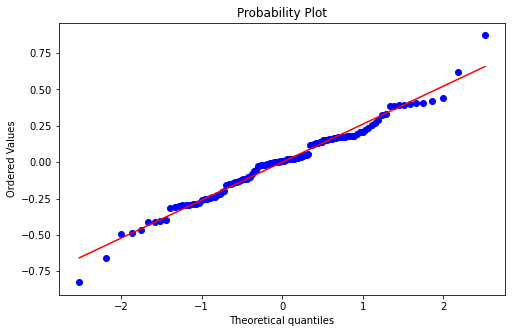

In [304]:
# apply normal probability plot to assess how the data (error) depart from normality visually:
# The good fit indicates that normality is a reasonable approximation.

fig, ax = plt.subplots(figsize=(8,5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

In [315]:
# White's Test for Heteroskedasticity

white_test = het_white(mod.resid,  mod.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

{'LM Statistic': 0.7220816763272413, 'LM-Test p-value': 0.6969505357056804, 'F-Statistic': 0.35396794287358013, 'F-Test p-value': 0.7026661397927044}


 If p < 0.05, then the model is heteroskedastic. But both the LM-test and F-test p-values are 0.69 and 0.7 > 0.05
 => model is homoskedastic

In [64]:
mod.resid.mean() # checks if the expected value of the residuals = 0

5.286776307738841e-19

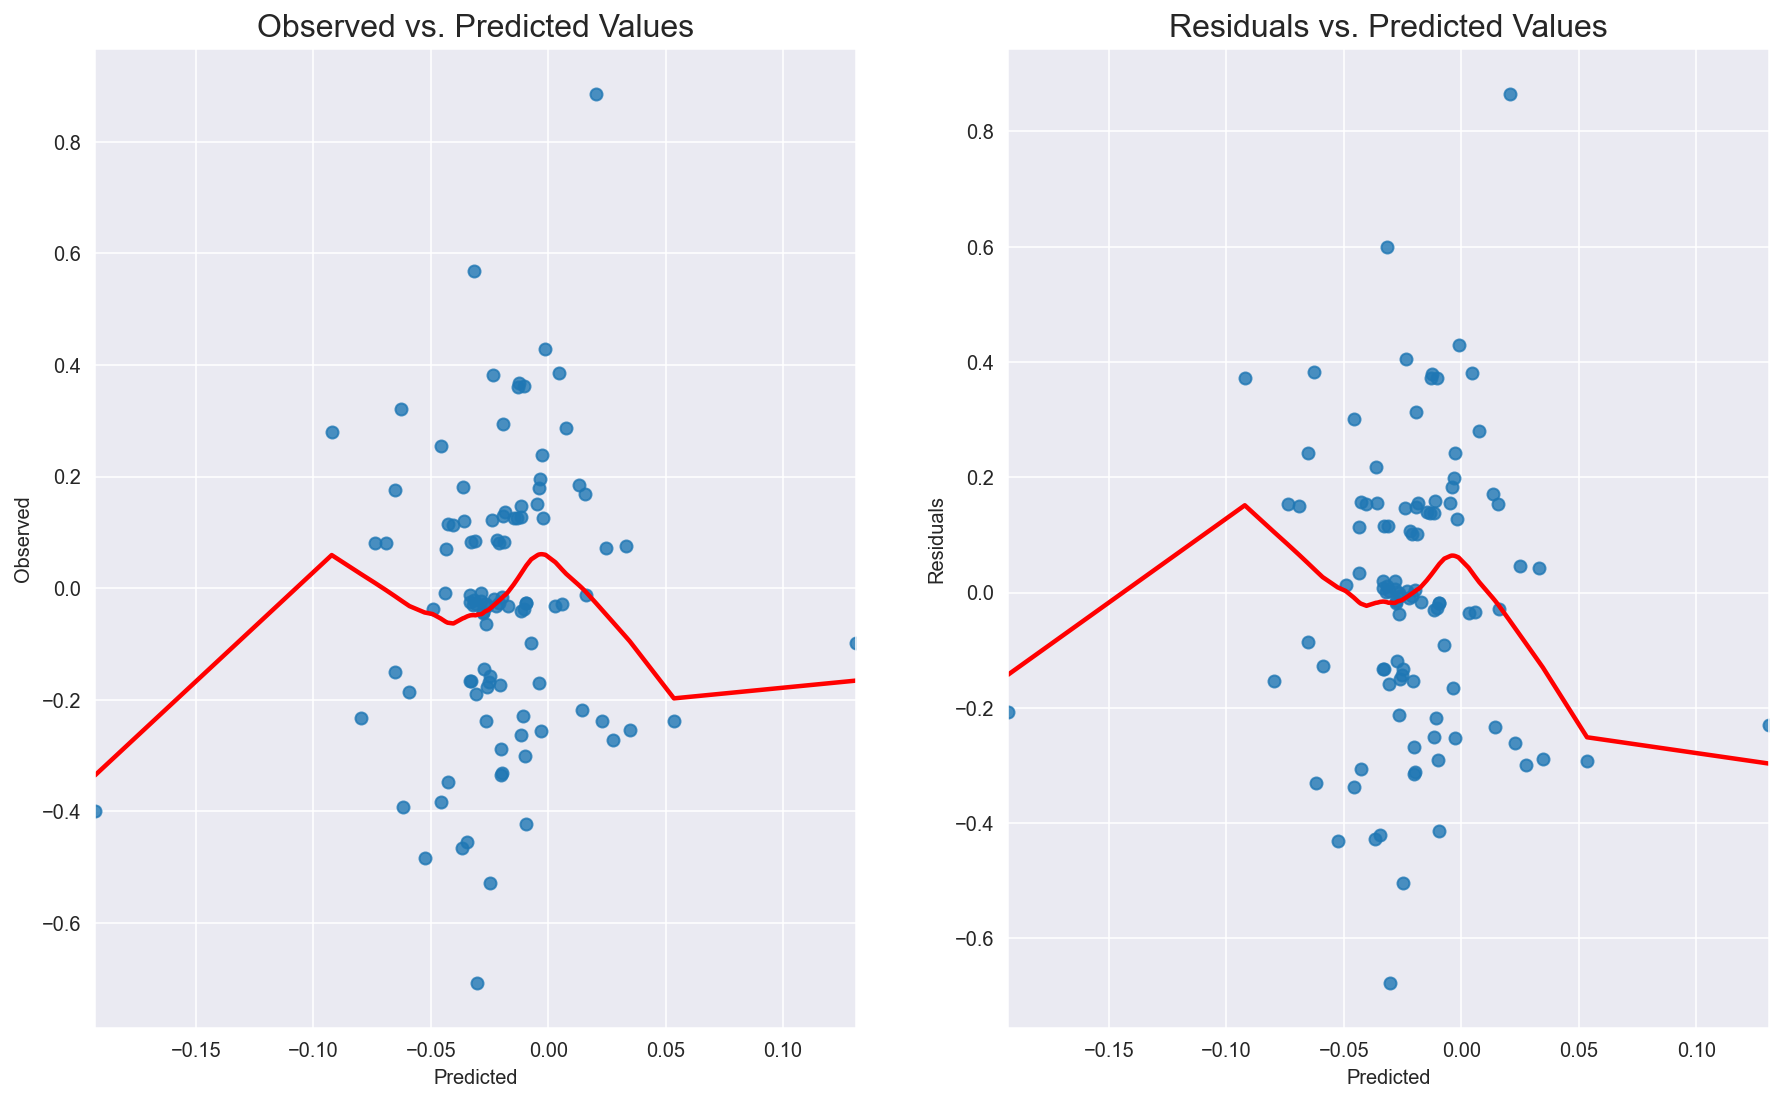

In [65]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(mod, y)  

In [203]:
price1['target_eciwag'] = price1['eciwag_ch'] - 0.0624*(2.5 - price1['pceindex_ch'])
price1.head()

pceindex  eciwag  eciwag_ch  pceindex_ch  target_eciwag
Date                                                               
1983-03-31    48.804    42.3   6.281407     4.411450       6.400682
1983-06-30    49.349    43.0   6.435644     4.146969       6.538414
1983-09-30    50.014    43.5   5.582524     4.313186       5.695667
1983-12-31    50.198    44.1   5.502392     3.646350       5.573925
1984-03-31    50.922    44.8   5.910165     4.339808       6.024970

In [204]:
price1['target_eciwag'].describe()

count    118.000000
mean       3.611367
std        1.076518
min        1.260065
25%        3.078318
50%        3.470405
75%        4.242633
max        6.538414
Name: target_eciwag, dtype: float64

In [101]:
adfuller_test(unrategap['unrate_gap'], name = 'Unemployment Gap') 
print('\n')

     Augmented Dickey-Fuller Test on "Unemployment Gap" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -1.8471
  No. of Lags Chosen    = 9
  Critical Value 1%     = -3.5
  Critical Value 5%     = -2.892
  Critical Value 10%    = -2.583
 => P-Value = 0.3574. Weak evidence to reject the Null Hypothesis.
 => Series is non-stationary.




In [106]:
y = unrategap['pceindex_ch']
X = unrategap['unrate_gap']
X = sm.add_constant(X) ## add an intercept (beta_0) to the model


mod = sm.OLS(y, X).fit() ## sm.OLS(output, input)
pred = mod.predict(X) 

# Print out the statistics
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            pceindex_ch   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     10.62
Date:                Wed, 15 Jul 2020   Prob (F-statistic):            0.00151
Time:                        18:23:58   Log-Likelihood:                -154.52
No. Observations:                 106   AIC:                             313.0
Df Residuals:                     104   BIC:                             318.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5271      0.111     22.693      0.000       2.306       2.748
unrate_gap    -0.0130      0.004     -3.259      0.002      -0.021      -0.005
==============================================================================
Omnibus:                        0.034   Durbin-Watson:                   0.373
Prob(Omnibus):                  0.983   Jarque-Bera (JB):                0.174
Skew:                          -0.016   Prob(JB):                        0.917
Kurtosis:                       2.804   Cond. No.                         30.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:
unrategap[['unrate_gap', 'pceindex_ch', 'unrate', 'eciwag_ch']].corr()

unrate_gap  pceindex_ch    unrate  eciwag_ch
unrate_gap     1.000000    -0.304435  0.975217  -0.606609
pceindex_ch   -0.304435     1.000000 -0.212829   0.567925
unrate         0.975217    -0.212829  1.000000  -0.547480
eciwag_ch     -0.606609     0.567925 -0.547480   1.000000

In [114]:
y = unrategap['eciwag_ch']
X = unrategap['unrate_gap']
X = sm.add_constant(X) ## add an intercept (beta_0) to the model


mod = sm.OLS(y, X).fit() ## sm.OLS(output, input)
pred = mod.predict(X) 

# Print out the statistics
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              eciwag_ch   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     60.55
Date:                Wed, 15 Jul 2020   Prob (F-statistic):           5.51e-12
Time:                        18:31:19   Log-Likelihood:                -111.81
No. Observations:                 106   AIC:                             227.6
Df Residuals:                     104   BIC:                             232.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6518      0.074     49.066      0.000       3.504       3.799
unrate_gap    -0.0208      0.003     -7.781      0.000      -0.026      -0.015
==============================================================================
Omnibus:                        6.797   Durbin-Watson:                   0.120
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.012
Skew:                           0.503   Prob(JB):                       0.0495
Kurtosis:                       2.410   Cond. No.                         30.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""